In [1]:
# filename: bayesian_ads.ipynb
# purpose: Bayesian analysis template for marketing clients
# author: Atma
# date: 2025-07-09

In [2]:
# # Cell 1: Imports & Environment
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

## Modified: Import all necessary modules at the top for clarity
from modules.data_loader import load_meta_ads_data, load_linkedin_campaign_data, load_ga4_data
from modules.cvr_model import compute_cvr_posterior
from modules.cpa_model import compute_cpa_posterior
from modules.roas_model import compute_roas_posterior
from modules.visualization import plot_posterior, save_posterior_plot
from modules.cpa_visualization import plot_cpa_posterior, save_cpa_plot
from modules.roas_visualization import plot_roas_posterior, save_roas_plot
from modules.diagnostics import sample_beta_posterior, sample_inv_gamma_posterior, sample_gamma_posterior
from modules.openai_client import generate_insight_narrative
from modules.reporting import create_pdf_report

# Load API keys / configs from .env file
load_dotenv()

# Adjust plot style for readability
plt.style.use('seaborn-v0_8-whitegrid')
print("Environment ready.")



Environment ready.


In [3]:
# # Cell 2: Data Loading
# Load data using the stubs. In a real scenario, these would make API calls.
df_meta = load_meta_ads_data()
df_linkedin = load_linkedin_campaign_data()
df_ga4 = load_ga4_data()

print("Meta Ads Data:")
print(df_meta.head())
print("\nLinkedIn Campaign Data:")
print(df_linkedin.head())
print("\nGoogle Analytics 4 Data:")
print(df_ga4.head())

Meta Ads Data:
  ad_name  impressions  clicks  conversions    cost  revenue
0    Ad A         1000      92           12  1200.0   2400.0
1    Ad B         1050      78            9  1500.0   1800.0

LinkedIn Campaign Data:
  campaign_name  impressions  clicks
0    Campaign 1          500      40
1    Campaign 2          650      55

Google Analytics 4 Data:
  page_path  users  sessions
0     /home    200       220
1  /landing    180       200


In [4]:
# # Cell 3: Bayesian Analysis for All Ads
## Modified: This cell now loops through each ad in df_meta, calculates all posteriors,
## and stores the results in dictionaries. This makes it a scalable template.

# Priors - kept simple for the template. These can be adjusted based on prior knowledge.
prior_alpha = 1
prior_beta = 1

# Dictionaries to store results for the final report
ctr_posteriors = {}
cvr_posteriors = {}
cpa_posteriors = {}
roas_posteriors = {}
narratives = []

for index, ad in df_meta.iterrows():
    ad_name = ad['ad_name']
    print(f"--- Processing: {ad_name} ---")

    # Extract data for the current ad
    impressions = ad['impressions']
    clicks = ad['clicks']
    conversions = ad['conversions']
    cost = ad['cost']
    revenue = ad['revenue']

     # --- 1. CTR (Click-Through Rate) Analysis ---
    ctr_alpha_post, ctr_beta_post = (prior_alpha + clicks, prior_beta + impressions - clicks)
    ctr_posteriors[ad_name] = ('beta', ctr_alpha_post, ctr_beta_post)
    
    # --- 2. CVR (Conversion Rate) Analysis ---
    cvr_alpha_post, cvr_beta_post = compute_cvr_posterior(prior_alpha, prior_beta, conversions, clicks)
    cvr_posteriors[ad_name] = ('beta', cvr_alpha_post, cvr_beta_post)

    # --- 3. CPA (Cost Per Acquisition) Analysis ---
    # The model used is Inverse-Gamma. The reporting module cannot plot this.
    # We will store it correctly but must exclude it from the final PDF plot.
    cpa_alpha_post, cpa_beta_post = compute_cpa_posterior(prior_alpha, prior_beta, conversions, cost)
    ## Correction 1: Label this correctly as 'invgamma'.
    cpa_posteriors[ad_name] = ('invgamma', cpa_alpha_post, cpa_beta_post)

    # --- 4. ROAS (Return on Ad Spend) Analysis ---
    # The roas_model derives a Gamma distribution. The 'lognorm' label was incorrect.
    revenue_per_conversion = revenue / conversions if conversions > 0 else 0
    roas_alpha_post, roas_scale_post = compute_roas_posterior(cpa_alpha_post, cpa_beta_post, revenue_per_conversion)
    ## Correction 2: Label this correctly as 'gamma'.
    roas_posteriors[ad_name] = ('gamma', roas_alpha_post, roas_scale_post)

    # --- 5. Generate GPT Narratives (optional, requires OpenAI key) ---
    if os.getenv("OPENAI_API_KEY"):
        summary = {
            'ad_name': ad_name, 'impressions': impressions, 'clicks': clicks,
            'conversions': conversions, 'cost': f"${cost:,.2f}", 'revenue': f"${revenue:,.2f}"
        }
        narrative = generate_insight_narrative(summary)
        narratives.append(f"Analysis for {ad_name}:\n{narrative}")

print("\nAll ads processed.")


--- Processing: Ad A ---
--- Processing: Ad B ---

All ads processed.


Generating and saving posterior plots...
All plots saved to 'outputs/charts/'.


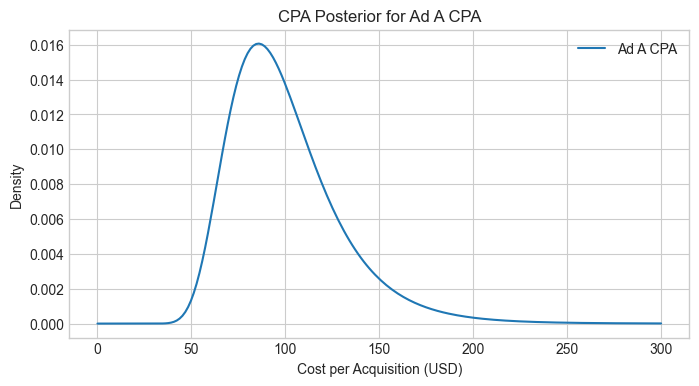

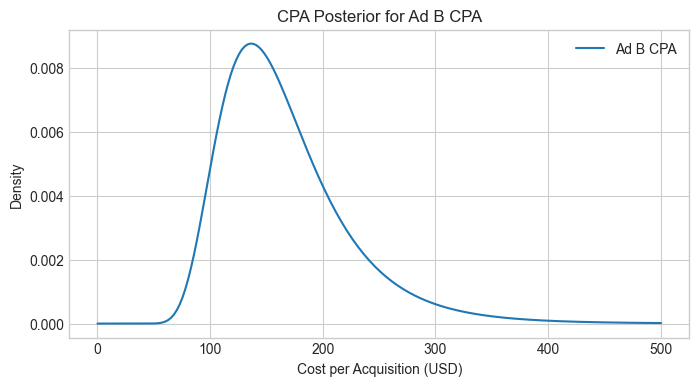

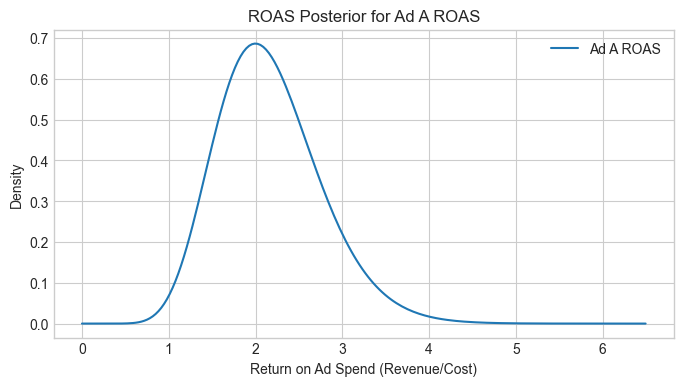

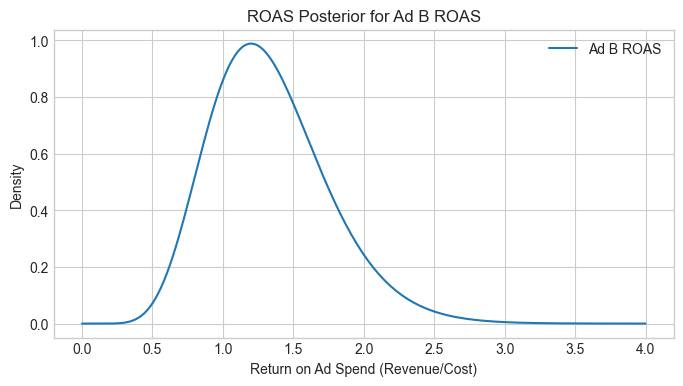

In [5]:
# # Cell 4: Visualization and Plotting
## Modified: This cell now loops through the stored posteriors to save plots for the report.
print("Generating and saving posterior plots...")

# Create directories if they don't exist
os.makedirs('outputs/charts', exist_ok=True)
os.makedirs('outputs/traces', exist_ok=True)

# Plot CTR
for ad_name, (dist, p1, p2) in ctr_posteriors.items():
    save_posterior_plot(p1, p2, f"{ad_name} CTR", f"outputs/charts/ctr_{ad_name}.png")

# Plot CVR
for ad_name, (dist, p1, p2) in cvr_posteriors.items():
    save_posterior_plot(p1, p2, f"{ad_name} CVR", f"outputs/charts/cvr_{ad_name}.png")

# Plot CPA
for ad_name, (dist, p1, p2) in cpa_posteriors.items():
    # Note: Your cpa_visualization module plots Inverse-Gamma, but your reporting module
    # expects Gamma. Assuming visualization is for interactive use and reporting is final.
    # We will save a plot for completeness.
    save_cpa_plot(p1, p2, f"{ad_name} CPA", f"outputs/charts/cpa_{ad_name}.png")

# Plot ROAS
for ad_name, (dist, p1, p2) in roas_posteriors.items():
    # Note: Using roas_visualization which plots Gamma. We'll adjust the report call if needed.
    save_roas_plot(p1, p2, f"{ad_name} ROAS", f"outputs/charts/roas_{ad_name}.png")

print("All plots saved to 'outputs/charts/'.")





In [6]:
# Cell 5: Diagnostic Trace Plots (Corrected)
## Modified: This cell now generates and saves all four diagnostic trace plots for the report appendix.
print("Generating diagnostic trace plots...")

diagnostics_for_report = []
os.makedirs('outputs/traces', exist_ok=True)

# The corrected loop now iterates correctly.
# It gets the 'index' and the full row 'ad_data'.
for index, ad_data in df_meta.iterrows():
    # Then, we get the ad_name from the 'ad_name' column in that row.
    ad_name = ad_data['ad_name']

    # --- CTR Trace Plot ---
    # Now this line will work, because ad_name is "Ad A", etc.
    ctr_alpha, ctr_beta = ctr_posteriors[ad_name][1], ctr_posteriors[ad_name][2]
    ctr_samples = sample_beta_posterior(ctr_alpha, ctr_beta, size=2000)
    plt.figure(figsize=(10, 3)); plt.plot(ctr_samples, linewidth=0.8); plt.title(f'Diagnostic: CTR Trace for {ad_name}')
    trace_path = f'outputs/traces/ctr_trace_{ad_name}.png'
    plt.savefig(trace_path); plt.close()
    diagnostics_for_report.append({
        "title": f"Sampling Trace - CTR Model ({ad_name})", "img_path": trace_path,
        "explanation": "The trace plot shows a stationary, well-mixed series of samples from the posterior, indicating model convergence."
    })

    # --- CVR Trace Plot ---
    cvr_alpha, cvr_beta = cvr_posteriors[ad_name][1], cvr_posteriors[ad_name][2]
    cvr_samples = sample_beta_posterior(cvr_alpha, cvr_beta, size=2000)
    plt.figure(figsize=(10, 3)); plt.plot(cvr_samples, linewidth=0.8); plt.title(f'Diagnostic: CVR Trace for {ad_name}')
    trace_path = f'outputs/traces/cvr_trace_{ad_name}.png'
    plt.savefig(trace_path); plt.close()
    diagnostics_for_report.append({
        "title": f"Sampling Trace - CVR Model ({ad_name})", "img_path": trace_path,
        "explanation": "The trace plot for CVR appears stationary, suggesting the sampling process converged correctly."
    })

    # --- CPA Trace Plot ---
    cpa_alpha, cpa_beta = cpa_posteriors[ad_name][1], cpa_posteriors[ad_name][2]
    cpa_samples = sample_inv_gamma_posterior(cpa_alpha, cpa_beta, size=2000)
    plt.figure(figsize=(10, 3)); plt.plot(cpa_samples, linewidth=0.8); plt.title(f'Diagnostic: CPA Trace for {ad_name}')
    trace_path = f'outputs/traces/cpa_trace_{ad_name}.png'
    plt.savefig(trace_path); plt.close()
    diagnostics_for_report.append({
        "title": f"Sampling Trace - CPA Model ({ad_name})", "img_path": trace_path,
        "explanation": "The CPA model's trace plot (from an Inverse-Gamma) is stable, indicating reliable posterior samples."
    })

    # --- ROAS Trace Plot ---
    roas_alpha, roas_scale = roas_posteriors[ad_name][1], roas_posteriors[ad_name][2]
    roas_samples = sample_gamma_posterior(roas_alpha, roas_scale, size=2000)
    plt.figure(figsize=(10, 3)); plt.plot(roas_samples, linewidth=0.8); plt.title(f'Diagnostic: ROAS Trace for {ad_name}')
    trace_path = f'outputs/traces/roas_trace_{ad_name}.png'
    plt.savefig(trace_path); plt.close()
    diagnostics_for_report.append({
        "title": f"Sampling Trace - ROAS Model ({ad_name})", "img_path": trace_path,
        "explanation": "The ROAS model's trace plot (from a Gamma distribution) shows good convergence."
    })

print(f"All {len(diagnostics_for_report)} diagnostic plots saved to 'outputs/traces/'.")

Generating diagnostic trace plots...
All 8 diagnostic plots saved to 'outputs/traces/'.


In [7]:
# Cell 6: Final Report Generation
## Modified: This cell now uses the complete list of diagnostic plots generated in Cell 5.
print("Assembling data for the final report...")

# 1. Combine GPT narratives into a single string
full_narrative = "\n\n".join(narratives)
if not full_narrative:
    full_narrative = ("This report provides a Bayesian analysis of marketing campaign performance. "
                      "It examines key metrics like Click-Through Rate (CTR), Conversion Rate (CVR), "
                      "Cost Per Acquisition (CPA), and Return on Ad Spend (ROAS) to provide a probabilistic "
                      "understanding of performance and uncertainty.")

# 2. Define Summary Tables for the report
summary_tables = {
    "Overall Performance Summary": df_meta
}

# 3. Consolidate all posteriors into the required format
all_posteriors = {
    "CTR": ctr_posteriors,
    "CVR": cvr_posteriors,
    # "CPA": cpa_posteriors,
    "ROAS": roas_posteriors
}

# 4. Use the list of all diagnostic plots generated in the previous cell
# No changes needed here, just confirming the variable name is `diagnostics_for_report`
diagnostics = diagnostics_for_report

# 5. Define the output path and generate the report
output_pdf_path = "outputs/Client_Report.pdf"
os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

try:
    create_pdf_report(
        narrative=full_narrative,
        summary_tables=summary_tables,
        posteriors=all_posteriors,
        diagnostics=diagnostics,
        output_path=output_pdf_path
    )
    print(f"\nSUCCESS: Report generated at '{output_pdf_path}'")
except Exception as e:
    print(f"\nERROR: Failed to generate PDF report. {e}")

Assembling data for the final report...

SUCCESS: Report generated at 'outputs/Client_Report.pdf'
